In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pandas as pd
import random

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

In [10]:
path = "/Users/muhammadhussain/Desktop/Data/filter/finished.parquet"
df = pd.read_parquet(path)
data = df.to_numpy()

In [24]:
evaldatatrain = pd.read_parquet(path)
evaldatatrain = evaldatatrain.drop(columns=["main_fault_0", "Type_0", "Event_0"])
evaldatatrain

,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_23,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber
0,0.455090,0.463855,0.469880,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:29:12,Refrigerant leakage at stage 1,806017
1,0.461078,0.469880,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:30:12,Refrigerant leakage at stage 1,806017
2,0.467066,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:31:12,Refrigerant leakage at stage 1,806017
3,0.467066,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,0.355422,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:32:12,Refrigerant leakage at stage 1,806017
4,0.467066,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,0.355422,0.343373,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:33:12,Refrigerant leakage at stage 1,806017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66023,0.467066,0.469880,0.469880,0.463855,0.451807,0.433735,0.397590,0.379518,0.355422,0.343373,...,0.157895,0.157895,0.157895,0.000000,0.000000,0.000000,0.000000,2013-02-24 10:58:12,None,806278
66024,0.467066,0.469880,0.463855,0.451807,0.433735,0.397590,0.379518,0.355422,0.343373,0.343373,...,0.157895,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,2013-02-24 10:59:12,None,806278
66025,0.467066,0.463855,0.451807,0.433735,0.397590,0.379518,0.355422,0.343373,0.343373,0.355422,...,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013-02-24 11:00:12,None,806278
66026,0.461078,0.451807,0.433735,0.397590,0.379518,0.355422,0.343373,0.343373,0.355422,0.367470,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013-02-24 11:01:12,None,806278


In [15]:
evaldatatrain["main_fault"].unique()

array(['Refrigerant leakage at stage 1', 'High condensation water',
       'electric_wiring', 'compressor_stage_1 malfunctional',
       'instability', None], dtype=object)

In [26]:
evaldatatrain['main_fault_numeric'] = pd.factorize(evaldatatrain['main_fault'].fillna('None'))[0]
evaldatatrain

,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber,main_fault_numeric
0,0.455090,0.463855,0.469880,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:29:12,Refrigerant leakage at stage 1,806017,0
1,0.461078,0.469880,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:30:12,Refrigerant leakage at stage 1,806017,0
2,0.467066,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:31:12,Refrigerant leakage at stage 1,806017,0
3,0.467066,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,0.355422,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:32:12,Refrigerant leakage at stage 1,806017,0
4,0.467066,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,0.355422,0.343373,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:33:12,Refrigerant leakage at stage 1,806017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66023,0.467066,0.469880,0.469880,0.463855,0.451807,0.433735,0.397590,0.379518,0.355422,0.343373,...,0.157895,0.157895,0.000000,0.000000,0.000000,0.000000,2013-02-24 10:58:12,None,806278,5
66024,0.467066,0.469880,0.463855,0.451807,0.433735,0.397590,0.379518,0.355422,0.343373,0.343373,...,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,2013-02-24 10:59:12,None,806278,5
66025,0.467066,0.463855,0.451807,0.433735,0.397590,0.379518,0.355422,0.343373,0.343373,0.355422,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013-02-24 11:00:12,None,806278,5
66026,0.461078,0.451807,0.433735,0.397590,0.379518,0.355422,0.343373,0.343373,0.355422,0.367470,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013-02-24 11:01:12,None,806278,5


In [35]:
from sklearn.model_selection import train_test_split
import torch

# Definer input og output
inp = evaldatatrain.drop(columns=["Datetime", "main_fault", "seriesnumber", "main_fault_numeric"])
time = evaldatatrain["Datetime"]
out = evaldatatrain["main_fault_numeric"]
seriesnumber = evaldatatrain["seriesnumber"]

# Split data i train, valid og test (40%, 40%, 20%)
x_temp, x_test, y_temp, y_test, time_temp, time_test, series_temp, series_test = train_test_split(
    inp, out, time, seriesnumber, test_size=0.2, stratify=out, random_state=42
)

x_train, x_valid, y_train, y_valid, time_train, time_valid, series_train, series_valid = train_test_split(
    x_temp, y_temp, time_temp, series_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Konverter til PyTorch tensors
x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
x_test = torch.tensor(x_test.values, dtype=torch.float32)

targets_train = torch.tensor(y_train.values, dtype=torch.int64)
targets_valid = torch.tensor(y_valid.values, dtype=torch.int64)
targets_test = torch.tensor(y_test.values, dtype=torch.int64)

# Lav også tids- og seriesnummerlister for senere analyse
time_train = time_train.reset_index(drop=True)
time_valid = time_valid.reset_index(drop=True)
time_test = time_test.reset_index(drop=True)

series_train = series_train.reset_index(drop=True)
series_valid = series_valid.reset_index(drop=True)
series_test = series_test.reset_index(drop=True)

# Bekræft fordelingen med pandas value_counts()
print("Train target distribution:", y_train.value_counts().to_dict())
print("Valid target distribution:", y_valid.value_counts().to_dict())
print("Test target distribution:", y_test.value_counts().to_dict())


Train target distribution: {0: 7016, 4: 6816, 3: 3397, 2: 3396, 1: 3385, 5: 2401}
Valid target distribution: {0: 7016, 4: 6816, 2: 3397, 3: 3396, 1: 3385, 5: 2401}
Test target distribution: {0: 3508, 4: 3408, 2: 1699, 3: 1699, 1: 1692, 5: 1200}


In [36]:
# To speed up training we'll only work on a subset of the data
#x_train = inp[:round(len(inp)/3)]
#targets_train = out[:round(len(inp)/3)]

#x_valid = inp[round(len(inp)/3):round(2*len(inp)/3)]
#targets_valid = out[round(len(inp)/3):round(2*len(inp)/3)]

#x_test = inp[round(2*len(inp)/3):]
#targets_test = out[round(2*len(inp)/3):]

#from sklearn.model_selection import train_test_split
#import torch

#x_train = inp[:1000]
#targets_train = out[:1000]

#x_valid = inp[1000:2000]
#targets_valid = out[1000:2000]

#x_test = inp[2000:3000]
#targets_test = out[2000:3000]


print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([26411, 360])
targets_train torch.Size([26411])
x_valid torch.Size([26411, 360])
targets_valid torch.Size([26411])
x_test torch.Size([13206, 360])
targets_test torch.Size([13206])


In [42]:
#Hyperparameters
num_classes = 6 
num_l1 = 128
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # batchNorm
        self.norm1 = nn.BatchNorm1d(num_features=num_hidden)
        # dropout layer
        self.dropout = nn.Dropout(0.2)
        # hidden layer 1
        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden * 2, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden*2), 0))
    

        self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(num_output, num_hidden * 2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))

        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.dropout(x)

        x = F.linear(x, self.W_1, self.b_1)
        x = self.norm1(x)
        x = self.activation(x)

        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        x = F.linear(x, self.W_3, self.b_3)

        return x


net = Net(num_features, num_l1, num_classes)

In [39]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 5.687914 , Train acc 0.074432, Valid acc 0.076591
Epoch 11 : Train Loss 5.674090 , Train acc 0.074583, Valid acc 0.076932
Epoch 21 : Train Loss 5.672677 , Train acc 0.072765, Valid acc 0.074962
Epoch 31 : Train Loss 5.693006 , Train acc 0.075303, Valid acc 0.077121
Epoch 41 : Train Loss 5.687933 , Train acc 0.068712, Valid acc 0.068788
Epoch 51 : Train Loss 5.691406 , Train acc 0.068674, Valid acc 0.069659
Epoch 61 : Train Loss 5.702168 , Train acc 0.071402, Valid acc 0.072803
Epoch 71 : Train Loss 5.682606 , Train acc 0.070795, Valid acc 0.072045
Epoch 81 : Train Loss 5.692877 , Train acc 0.070644, Valid acc 0.071894
Epoch 91 : Train Loss 5.690835 , Train acc 0.065189, Valid acc 0.065909
Epoch 101 : Train Loss 5.671825 , Train acc 0.069621, Valid acc 0.070530
Epoch 111 : Train Loss 5.685435 , Train acc 0.072576, Valid acc 0.074659
Epoch 121 : Train Loss 5.695487 , Train acc 0.072311, Valid acc 0.075265
Epoch 131 : Train Loss 5.678311 , Train acc 0.070076, Valid a

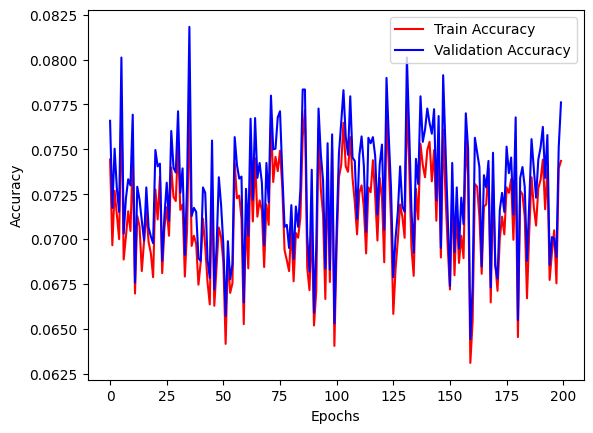

In [43]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score
import torch
import numpy as np
import matplotlib.pyplot as plt

# setting hyperparameters and getting epoch sizes
batch_size = 100
num_epochs = 200
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprop -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

# Save the model's parameters
model_path = "trained_modelFFNN.pth"
torch.save(net.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot accuracy
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs'), plt.ylabel('Accuracy')
plt.show()


In [44]:
print(y_train.value_counts(normalize=True))
print(y_valid.value_counts(normalize=True))

main_fault_numeric
0    0.265647
4    0.258074
3    0.128621
2    0.128583
1    0.128166
5    0.090909
Name: proportion, dtype: float64
main_fault_numeric
0    0.265647
4    0.258074
2    0.128621
3    0.128583
1    0.128166
5    0.090909
Name: proportion, dtype: float64


In [45]:
# Indlæs modellen
net_loaded = Net(num_features, num_l1, num_classes)  # Sørg for at bruge samme arkitektur
net_loaded.load_state_dict(torch.load(model_path))
net_loaded.eval()  # Sæt modellen i evalueringsmodus

print("Model loaded successfully!")


Model loaded successfully!


In [46]:
net.eval()

Net(
  (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU()
)

In [50]:
output = net(x_test)
output

tensor([[ 0.1809,  0.4639, -0.5349,  0.0827, -0.2050,  0.0261],
        [ 0.1577,  0.6292, -0.2275,  0.8154, -0.7176,  0.2919],
        [ 0.2734,  0.3557,  0.1725,  0.6468,  0.2957,  0.1641],
        ...,
        [ 0.1755,  0.3633, -0.3720, -0.0826, -0.0926, -0.2291],
        [ 0.1389,  0.2872, -0.1154,  0.5127,  0.0138, -0.2582],
        [ 0.2806, -0.1428, -0.1287,  0.0369, -0.0678, -0.1951]],
       grad_fn=<AddmmBackward0>)

In [51]:
predictedclass = torch.argmax(output, dim=1)
predictedclass

tensor([1, 3, 3,  ..., 1, 3, 0])

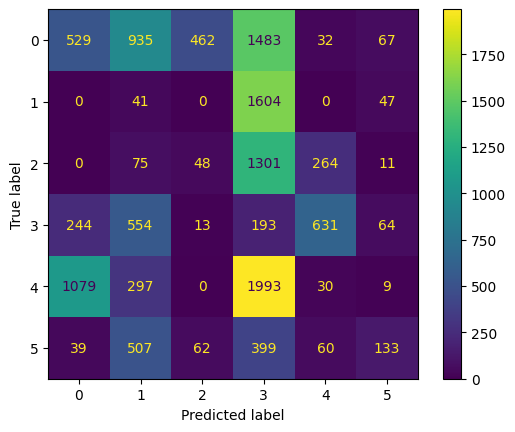

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


predictedclass = torch.argmax(net(x_test), dim=1)

cm = confusion_matrix(targets_test, predictedclass)
ConfusionMatrixDisplay(cm).plot()

In [53]:
binarypredictedclass = [1 if i > 0 else 0 for i in predictedclass]
binarytargets_test = [1 if i > 0 else 0 for i in targets_test]

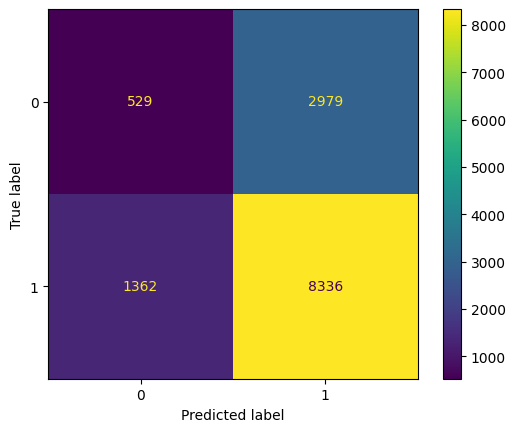

In [54]:
cm = confusion_matrix(binarytargets_test, binarypredictedclass)
ConfusionMatrixDisplay(cm).plot()

In [55]:
unique_values, counts = torch.unique(targets_train, return_counts=True)

print("Unikke værdier:", unique_values)
print("Hyppigheder:", counts)

Unikke værdier: tensor([0, 1, 2, 3, 4, 5])
Hyppigheder: tensor([7016, 3385, 3396, 3397, 6816, 2401])
